# Q1

In [438]:
#IMPORTING ALL THE LIBRARIES 
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType, BooleanType
from pyspark.sql.types import StructType, StructField, TimestampType, DateType, StringType
from pyspark.sql.functions import col, trim
from pyspark.sql.functions import unix_timestamp, current_timestamp
from pyspark.sql.functions import lit
from pyspark.sql.functions import when
from pyspark.sql.functions import count, avg, first, year
import seaborn as sb
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import roc_curve
import pyspark.sql.functions as F
import pyspark.sql.types as T
from matplotlib import pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, sum, when
import torch
import numpy as np
import pandas as pd

In [441]:
#Starting spark session
jdbc_jar_path = "postgresql-42.7.4.jar"

appName = "Project"
master = "local"

conf = SparkConf() \
    .set('spark.driver.host', '127.0.0.1') \
    .setAppName("HW6") \
    .setMaster("local[*]") \
    .set("spark.jars", jdbc_jar_path)

sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)
spark = sqlContext.sparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("FATAL")


In [442]:
#reading data
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","classes","difficulty"]

directory_train = "/Users/janbol/Documents/Career Documents/Carnegie Mellon University/CMU Courses/14-763 - Systems and Toolchains for AI Engineers/Week 5/HW5/NSL-KDD/KDDTrain+.txt"
directory_test = "/Users/janbol/Documents/Career Documents/Carnegie Mellon University/CMU Courses/14-763 - Systems and Toolchains for AI Engineers/Week 5/HW5/NSL-KDD/KDDTest+.txt"

df = spark.read.csv(directory_train,header=False, inferSchema= True).toDF(*col_names)
df2 = spark.read.csv(directory_test,header=False, inferSchema= True).toDF(*col_names)
df_validation, df_test = df2.randomSplit([0.5, 0.5], seed=123)

In [1]:
#Dr.Guannan, Lecture 9 and 10 notes.
nominal_cols = ['protocol_type','service','flag']

binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']

continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

#creating a class that will assign appriopriate main classes based on sub-classes of attacks
class SubToMain(Transformer):
    def __init__(self):
        super().__init__()
    def _transform(self, dataset):
        multi_class = udf( lambda name: 
                          'normal' if name == 'normal' 
                          else 'DOS' if name in ['back', 'neptune', 'smurf', 'teardrop', 'land', 'pod']
                          else 'R2L' if name in ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'spy', 'warezmaster', 'warezclient', 'phf']
                          else 'U2R' if name in ['buffer_overflow', 'rootkit', 'loadmodule', 'perl']
                          else 'probing' if name in ['satan', 'nmap', 'portsweep', 'ipsweep']
                          else None)

        output_df = dataset.withColumn('outcome', multi_class(col('classes'))).drop("classes")        
        output_df = output_df.drop('difficulty')
        return output_df
        
class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df
class RowDropper(Transformer): # this transformer drops unnecessary rows which has None/Null values.
    def __init__(self):
        super().__init__()
    def _transform(self, dataset):
        output_df = dataset.dropna(subset=['outcome'])  # Drop rows with nulls in 'outcome'
        return output_df


def process_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_maincat = SubToMain()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])

    stage_maincat_nominal = StringIndexer(inputCol = "outcome", outputCol = "outcome_index" )
    stage_maincat_onehot = OneHotEncoder(inputCol = "outcome_index", outputCol= "outcome_onehot", dropLast = False)

    #Dropping extra unseen labels for the trainig set
    rowdrop = RowDropper()

    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_maincat,stage_column_dropper,rowdrop, stage_maincat_nominal, stage_maincat_onehot])

    return pipeline 

NameError: name 'Transformer' is not defined

In [444]:
def run_pipeline(dataframe):
    preprocess_pipeline = process_pipeline()
    preprocessed = preprocess_pipeline.fit(df)
    transformed = preprocessed.transform(dataframe)
    return transformed

train_df = run_pipeline(df)
validation_df = run_pipeline(df_validation)
test_df = run_pipeline(df_test)




In [215]:
#showing that main class column has been created according to the subclasses
train_df.show(20)

+--------------------+-------+-------------+--------------+
|            features|outcome|outcome_index|outcome_onehot|
+--------------------+-------+-------------+--------------+
|(113,[1,13,14,17,...| normal|          0.0| (5,[0],[1.0])|
|(113,[1,13,14,17,...| normal|          0.0| (5,[0],[1.0])|
|(113,[13,14,15,17...|    DOS|          1.0| (5,[1],[1.0])|
|(113,[1,2,13,14,1...| normal|          0.0| (5,[0],[1.0])|
|(113,[1,2,13,14,1...| normal|          0.0| (5,[0],[1.0])|
|(113,[13,14,16,17...|    DOS|          1.0| (5,[1],[1.0])|
|(113,[13,14,15,17...|    DOS|          1.0| (5,[1],[1.0])|
|(113,[13,14,15,17...|    DOS|          1.0| (5,[1],[1.0])|
|(113,[13,14,15,17...|    DOS|          1.0| (5,[1],[1.0])|
|(113,[13,14,15,17...|    DOS|          1.0| (5,[1],[1.0])|
|(113,[13,14,16,17...|    DOS|          1.0| (5,[1],[1.0])|
|(113,[13,14,15,17...|    DOS|          1.0| (5,[1],[1.0])|
|(113,[1,2,13,14,1...| normal|          0.0| (5,[0],[1.0])|
|(113,[1,13,14,17,...|    R2L|          

In [73]:
train_df.select("outcome").distinct().show()

+-------+
|outcome|
+-------+
|probing|
|    R2L|
| normal|
|    DOS|
|    U2R|
+-------+



In [124]:
train_df.count()

125973

In [74]:
validation_df.select("outcome").distinct().show()

+-------+
|outcome|
+-------+
|probing|
|    R2L|
| normal|
|    DOS|
|    U2R|
+-------+



In [75]:
validation_df.show(20)

+--------------------+-------+-------------+--------------+
|            features|outcome|outcome_index|outcome_onehot|
+--------------------+-------+-------------+--------------+
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          

In [76]:
test_df.select("outcome").distinct().show()

+-------+
|outcome|
+-------+
|probing|
|    R2L|
| normal|
|    DOS|
|    U2R|
+-------+



In [77]:
test_df.show(20)

+--------------------+-------+-------------+--------------+
|            features|outcome|outcome_index|outcome_onehot|
+--------------------+-------+-------------+--------------+
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          2.0| (5,[2],[1.0])|
|(113,[1,13,14,17,...|probing|          

# Q2

In [445]:
#defining function to turn Spark df to Torch
def spark_to_torch(dataframe, x, y):
    pandas_df = dataframe.toPandas()
    x_train = torch.from_numpy(np.array(pandas_df[f'{x}'].values.tolist(), np.float32))
    y_train = torch.from_numpy(np.array(pandas_df[f'{y}'].values.tolist(), np.int64))    
    return x_train, y_train

#converting Spark df to Torch
x_train, y_train = spark_to_torch(train_df, "features", "outcome_index")
x_validate, y_validate = spark_to_torch (validation_df, "features", "outcome_index")
x_test, y_test = spark_to_torch (test_df, "features", "outcome_index")

In [446]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset): 
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return (self.x[idx],self.y[idx])

training_set = MyDataset(x_train, y_train)
validation_set = MyDataset(x_validate, y_validate)
testing_set = MyDataset(x_test, y_test)


In [447]:
###
# USING MPS ACCELARATION
###
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available!")
else:
    print("MPS backend is not available.")

# Using the MPS acceleration
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


MPS backend is available!


In [422]:
from torch import nn
class myMultiLayerPerceptron(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential = nn.Sequential(  # here we stack multiple layers together
            nn.Linear(input_dim,55),
            nn.ReLU(),
            nn.Linear(55,30),
            nn.ReLU(),
            nn.Linear(30,20),
            nn.ReLU(),
            nn.Linear(20,10),
            nn.ReLU(),
            nn.Linear(10,output_dim)   
        )
    def forward(self,x):
        y = self.sequential(x)
        return y
    
# Let's check out our model 

mymodel = myMultiLayerPerceptron(113, 5) # creating a model instance with input dimension 1 and output dimension 1
mymodel.to(device)
print(mymodel)

myMultiLayerPerceptron(
  (sequential): Sequential(
    (0): Linear(in_features=113, out_features=55, bias=True)
    (1): ReLU()
    (2): Linear(in_features=55, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=5, bias=True)
  )
)


# Q3

In [423]:
#hypertuning parameters
lr = 0.008
batch_size = 300
N_epochs = 12

loss_fun = nn.CrossEntropyLoss()
train_dataloader = DataLoader(training_set, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validation_set,batch_size = batch_size,shuffle = True)

optimizer = torch.optim.SGD(mymodel.parameters(), lr = lr)

losses = []
accuracies = []
validate_losses = []
validate_accuracies = []
current_best_accuracy = 0.0
losses_all = [] 
raw_batch_loss = []

for epoch in range(N_epochs):
    batch_loss = []
    batch_accuracy = []
    ###
    #TRAINING LOOP
    ###
    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().cpu().numpy())
        prediction_label = torch.argmax(prediction_score.detach(), dim=1).cpu().numpy()
        batch_accuracy.append(np.sum(prediction_label == y_batch.cpu().numpy())/(x_batch.shape[0]))
    ###
    #VALIDATION LOOP
    ###
    validate_batch_loss = []
    validate_batch_accuracy = []
    for x_batch, y_batch in validate_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score, y_batch)
        validate_batch_loss.append(loss.detach().cpu())
        prediction_label = torch.argmax(prediction_score.detach(), dim = 1).cpu().numpy()
        validate_batch_accuracy.append(np.sum(prediction_label == y_batch.cpu().numpy())/(x_batch.shape[0]))
    ###
    # APPENDNING LOSSES AND ACCURACIES
    ###
    losses.append(np.mean(np.array(batch_loss)))
    raw_batch_loss.append(np.array(batch_loss))
    accuracies.append(np.mean(np.array(batch_accuracy)))
    
    validate_losses.append(np.mean(np.array(validate_batch_loss)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))
    print(f"Epoch = {epoch}, train_loss={losses[-1]}, validate_loss = {validate_losses[-1]}")
    print(f"Train accuracy = {np.round(accuracies[-1]*100, 2)}%, validate accuracy = {np.round(validate_accuracies[-1]*100, 2)}%")

    if validate_accuracies[-1] > current_best_accuracy:
        print("Current epoch is the best so far. Saving Model...\n")
        torch.save(mymodel.state_dict(), "current_best_model")
        current_best_accuracy = validate_accuracies[-1]

Epoch = 0, train_loss=1.2271356582641602, validate_loss = 1.2138198614120483
Train accuracy = 53.46%, validate accuracy = 51.5%
Current epoch is the best so far. Saving Model...

Epoch = 1, train_loss=0.8806669116020203, validate_loss = 1.0533843040466309
Train accuracy = 61.12%, validate accuracy = 75.69%
Current epoch is the best so far. Saving Model...

Epoch = 2, train_loss=0.41612184047698975, validate_loss = 1.0788731575012207
Train accuracy = 87.6%, validate accuracy = 76.66%
Current epoch is the best so far. Saving Model...

Epoch = 3, train_loss=0.28014254570007324, validate_loss = 1.0886889696121216
Train accuracy = 90.03%, validate accuracy = 80.44%
Current epoch is the best so far. Saving Model...

Epoch = 4, train_loss=0.214504674077034, validate_loss = 1.0934021472930908
Train accuracy = 95.78%, validate accuracy = 80.9%
Current epoch is the best so far. Saving Model...

Epoch = 5, train_loss=0.17644359171390533, validate_loss = 1.0395721197128296
Train accuracy = 96.34%,

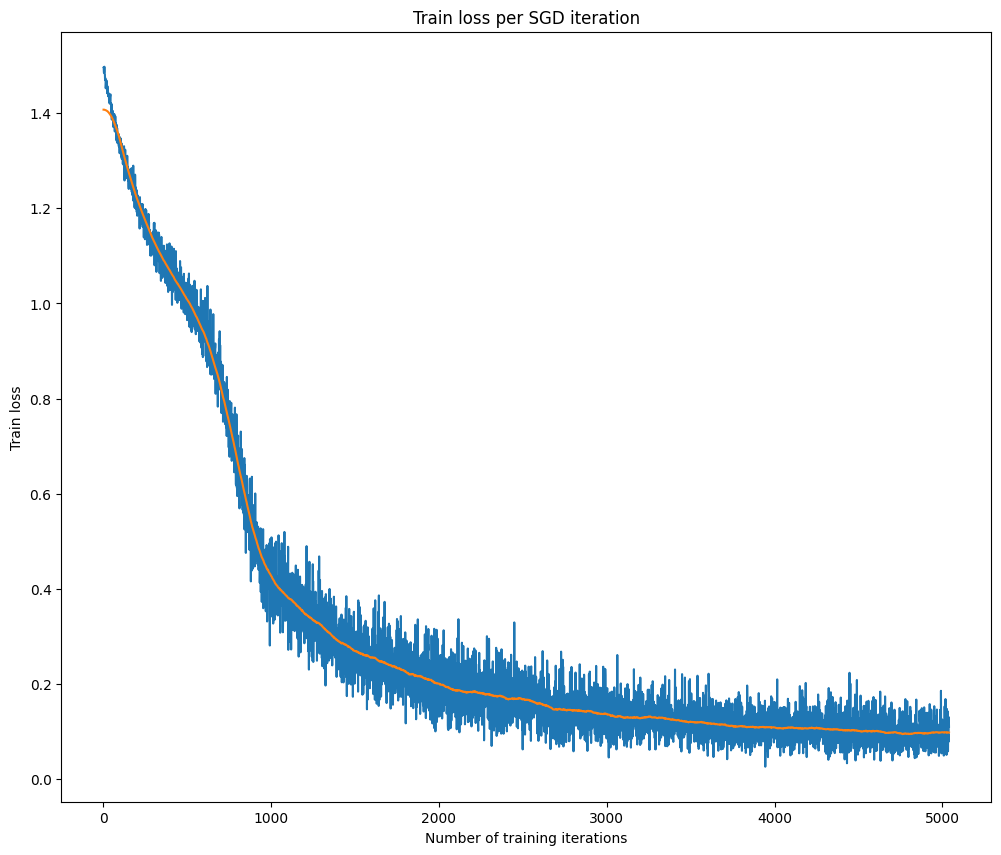

In [424]:
###
# Graph for train loss per SGD iteration
###
plt.figure(figsize = (12, 10))
combined_array = np.concatenate(raw_batch_loss)
x = range(1, len(combined_array)+1)
y = combined_array
plt.plot(x, y)
plt.title("Train loss per SGD iteration")
plt.xlabel("Number of training iterations")
plt.ylabel("Train loss")

###
# Because there are so many iterations, I have added smoothing to show the general trend in yellow.
###
from scipy.ndimage import uniform_filter1d
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.uniform_filter1d.html
smoothed_y = uniform_filter1d(y, size=200)
plt.plot(x, smoothed_y)

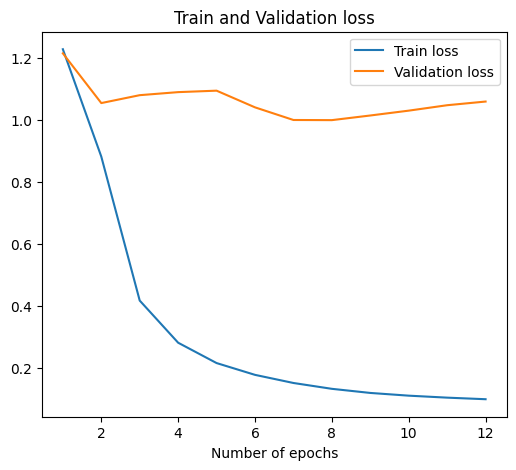

In [425]:
###
# Graph for train loss, validation loss per epoch
###

plt.figure(figsize = (6, 5))
x = range(1, len(losses)+1)
plt.title("Train and Validation loss")
plt.xlabel("Number of epochs")
plt.plot(x, losses, label = "Train loss")
plt.plot(x, validate_losses, label = "Validation loss")
plt.legend()
plt.show()

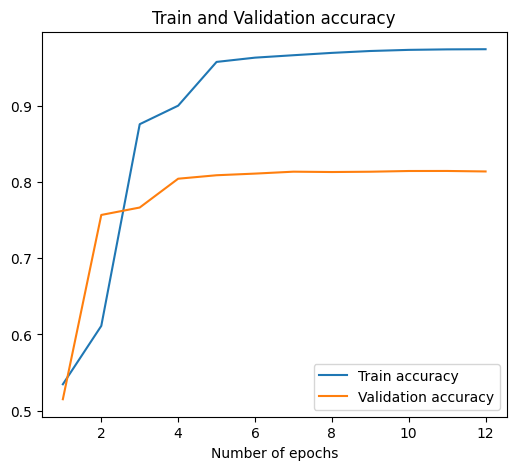

In [426]:
###
# Graph for train loss, validation loss per epoch
###

plt.figure(figsize = (6, 5))
x = range(1, len(losses)+1)
plt.title("Train and Validation accuracy")
plt.xlabel("Number of epochs")
plt.plot(x, accuracies, label = "Train accuracy")
plt.plot(x, validate_accuracies, label = "Validation accuracy")
plt.legend()
plt.show()

# Q4

In [448]:
from torch import nn
class myMultiLayerPerceptron(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential = nn.Sequential(  # here we stack multiple layers together
            nn.Linear(input_dim,55),
            nn.ReLU(),
            nn.Linear(55,20),
            nn.ReLU(),
            nn.Linear(20,10),
            nn.ReLU(),
            nn.Linear(10,7),
            nn.ReLU(),
            nn.Linear(7,output_dim)   
        )
    def forward(self,x):
        y = self.sequential(x)
        return y
    
# Let's check out our model 

mymodel_hyper = myMultiLayerPerceptron(113, 5) # creating a model instance with input dimension 1 and output dimension 1
mymodel_hyper.to(device)
print(mymodel_hyper)

myMultiLayerPerceptron(
  (sequential): Sequential(
    (0): Linear(in_features=113, out_features=55, bias=True)
    (1): ReLU()
    (2): Linear(in_features=55, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=7, bias=True)
    (7): ReLU()
    (8): Linear(in_features=7, out_features=5, bias=True)
  )
)


In [449]:
#hypertuning parameters
lr = 0.001
batch_size = 205
N_epochs = 10

loss_fun = nn.CrossEntropyLoss()
train_dataloader = DataLoader(training_set, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validation_set,batch_size = batch_size,shuffle = True)

optimizer = torch.optim.Adam(mymodel_hyper.parameters(), lr = lr)

losses = []
accuracies = []
validate_losses = []
validate_accuracies = []
current_best_accuracy = 0.0
losses_all = [] 
raw_batch_loss = []

for epoch in range(N_epochs):
    batch_loss = []
    batch_accuracy = []
    ###
    #TRAINING LOOP
    ###
    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        prediction_score = mymodel_hyper(x_batch)
        loss = loss_fun(prediction_score, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().cpu().numpy())
        prediction_label = torch.argmax(prediction_score.detach(), dim=1).cpu().numpy()
        batch_accuracy.append(np.sum(prediction_label == y_batch.cpu().numpy())/(x_batch.shape[0]))
    ###
    #VALIDATION LOOP
    ###
    validate_batch_loss = []
    validate_batch_accuracy = []
    with torch.no_grad():
        for x_batch, y_batch in validate_dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            prediction_score = mymodel_hyper(x_batch)
            loss = loss_fun(prediction_score, y_batch)
            validate_batch_loss.append(loss.detach().cpu())
            prediction_label = torch.argmax(prediction_score.detach(), dim = 1).cpu().numpy()
            validate_batch_accuracy.append(np.sum(prediction_label == y_batch.cpu().numpy())/(x_batch.shape[0]))
    ###
    # APPENDNING LOSSES AND ACCURACIES
    ###
    losses.append(np.mean(np.array(batch_loss)))
    raw_batch_loss.append(np.array(batch_loss))
    accuracies.append(np.mean(np.array(batch_accuracy)))
    
    validate_losses.append(np.mean(np.array(validate_batch_loss)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))
    print(f"Epoch = {epoch}, train_loss={losses[-1]}, validate_loss = {validate_losses[-1]}")
    print(f"Train accuracy = {np.round(accuracies[-1]*100, 2)}%, validate accuracy = {np.round(validate_accuracies[-1]*100, 2)}%")

    if validate_accuracies[-1] > current_best_accuracy:
        print("Current epoch is the best so far. Saving Model...\n")
        torch.save(mymodel_hyper.state_dict(), "current_best_model")
        current_best_accuracy = validate_accuracies[-1]

Epoch = 0, train_loss=0.28313374519348145, validate_loss = 0.9755821228027344
Train accuracy = 88.71%, validate accuracy = 82.55%
Current epoch is the best so far. Saving Model...

Epoch = 1, train_loss=0.048218484967947006, validate_loss = 1.091537594795227
Train accuracy = 98.25%, validate accuracy = 83.17%
Current epoch is the best so far. Saving Model...

Epoch = 2, train_loss=0.03481581062078476, validate_loss = 1.2292839288711548
Train accuracy = 98.86%, validate accuracy = 84.24%
Current epoch is the best so far. Saving Model...

Epoch = 3, train_loss=0.028365012258291245, validate_loss = 1.3676743507385254
Train accuracy = 99.22%, validate accuracy = 85.26%
Current epoch is the best so far. Saving Model...

Epoch = 4, train_loss=0.024445902556180954, validate_loss = 1.3774620294570923
Train accuracy = 99.34%, validate accuracy = 86.76%
Current epoch is the best so far. Saving Model...

Epoch = 5, train_loss=0.021476393565535545, validate_loss = 1.665831208229065
Train accuracy 

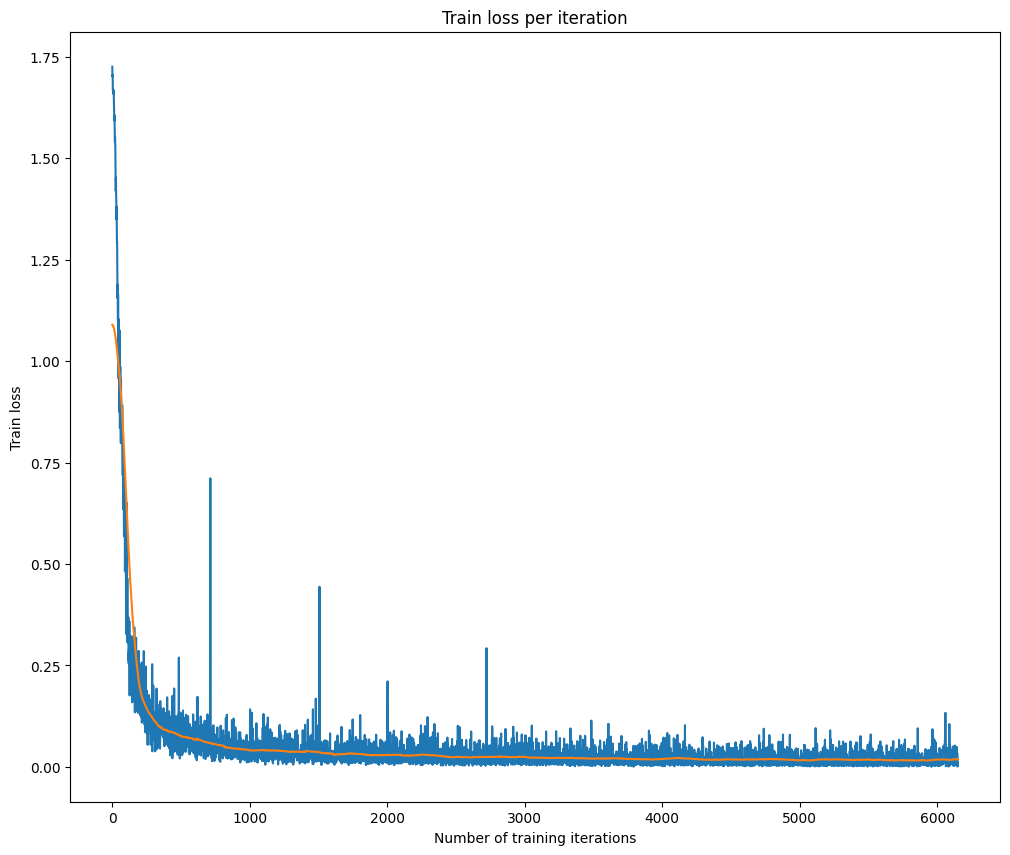

In [450]:
###
# Graph for train loss per iteration
###
plt.figure(figsize = (12, 10))
combined_array = np.concatenate(raw_batch_loss)
x = range(1, len(combined_array)+1)
y = combined_array
plt.plot(x, y)
plt.title("Train loss per iteration")
plt.xlabel("Number of training iterations")
plt.ylabel("Train loss")

###
# Because there are so many iterations, I have added smoothing to show the general trend in yellow.
###
from scipy.ndimage import uniform_filter1d
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.uniform_filter1d.html
smoothed_y = uniform_filter1d(y, size=200)
plt.plot(x, smoothed_y)

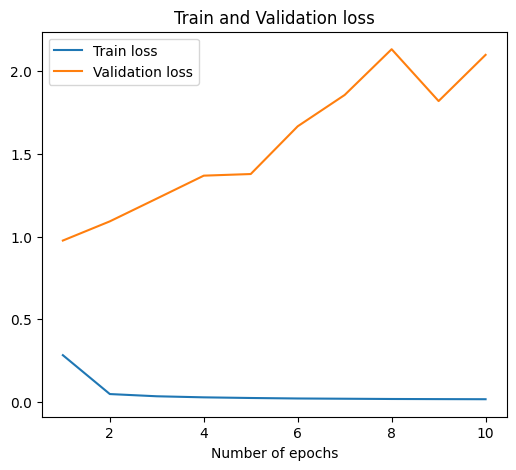

In [451]:
###
# Graph for train loss, validation loss per epoch
###

plt.figure(figsize = (6, 5))
x = range(1, len(losses)+1)
plt.title("Train and Validation loss")
plt.xlabel("Number of epochs")
plt.plot(x, losses, label = "Train loss")
plt.plot(x, validate_losses, label = "Validation loss")
plt.legend()
plt.show()

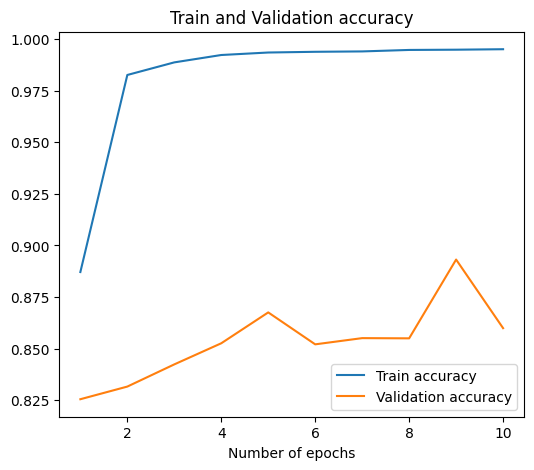

In [452]:
###
# Graph for train loss, validation loss per epoch
###

plt.figure(figsize = (6, 5))
x = range(1, len(losses)+1)
plt.title("Train and Validation accuracy")
plt.xlabel("Number of epochs")
plt.plot(x, accuracies, label = "Train accuracy")
plt.plot(x, validate_accuracies, label = "Validation accuracy")
plt.legend()
plt.show()

# Please provide a short description on your tuning process, including the rationale for choosing the hyper-parameters.

Following are the final hyper tuning parameters:

1. `lr = 0.001`
2. `batch_size = 205`
3. `N_epochs = 10`
4. `optimizer = torch.optim.Adam(mymodel_hyper.parameters(), lr = lr)`
5. NN structure
myMultiLayerPerceptron(

(sequential): Sequential(
  
    (0): Linear(in_features=113, out_features=55, bias=True)
    (1): ReLU()
    (2): Linear(in_features=55, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=7, bias=True)
    (7): ReLU()
    (8): Linear(in_features=7, out_features=5, bias=True)))


The hypertuning process was mostly based on Trial and Error. 

Initially learning rate of 0.0001 and even smaller was implemented, resulting in slow convergence and not reaching good accuracy on both training and validation dataset. `lr=0.001` seemed to be the sweet spot for fast convergence.

For `batch_size`, different values were explored. Although a larger `batch_size` of 300 made the training faster, it led to lower validation accuracy. Reducing it to 205 helped accuracy reach close to 89%

Testing with more than 10 epochs revealed diminishing returns. The model typically converged within the first 10 epochs, and subsequent epochs did not yield significant improvements. To optimize computational efficiency, I decided to maintain the `N_epochs` count at 10.

The most substantial improvememnt came from the neural network structure. My initial NN model with 3 layers reached a maximum validation accuracy of 80%. Although increasing the depth introduced higher risk of overfitting to the training data, 5 layers NN structure resulted in improved performance, raising validation accuracy to 89%.

For optimizer Adam was chosen as it allows faster convergence when compared to the SGD. When using lower learning rate, the convergence was quite slow with SGD.

# Q5

In [453]:
###
# Loading the best model
###
best_model = myMultiLayerPerceptron(113, 5)
best_model.to(device)
best_model.load_state_dict(torch.load("current_best_model"))

/var/folders/c5/p6q0gjzj2ns5lv27n9yp07ph0000gn/T/ipykernel_1485/820827973.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("current_

<All keys matched successfully>

In [454]:
batch_size = 300
test_dataloader = DataLoader(testing_set,batch_size = batch_size,shuffle = True)
test_batch_accuracy = []

for x_batch, y_batch in test_dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    with torch.no_grad():
        prediction = best_model(x_batch)

    prediction_label = torch.argmax(prediction.detach(), dim=1).cpu().numpy()
    test_batch_accuracy.append(np.sum(prediction_label == y_batch.cpu().numpy())/x_batch.shape[0])
test_accuracy = np.mean(np.array(test_batch_accuracy))
print(f"Test accuracy = {np.round(test_accuracy*100, 2)}%")



Test accuracy = 89.39%


# Note that when evaluating the metric, the gradient is not needed, and thus, building the computation graph is not necessary. What should you do to prevent PyTorch from building the computation graph in the evaluation process? Please explain your answer and include a screenshot of the relevant code.

Since there is no need for training while evaluating the model, there is also no need for backpropogation in NN which requires the calculation of gradients using the given Loss functions. In training these gradients are typically used to update the weights and biases to improve the accuracy and reduce loss after each batch. Since we do not need all these `with torch.no_grad(): prediction = best_model(x_batch)` was added to the testing part of the code, which will not store or compute the gradient, saving some computation cost. This will also prevent builing the copmutation graph.